In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay,  silhouette_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


In [2]:
df = pd.read_csv("/Users/yj.noh/Desktop/rfm_data.csv", encoding = "cp949")
print(df.isna().sum())

brms_rider_id       0
JOIN_WEEK           0
recency          9234
frequency        9234
monetary         9234
dtype: int64


In [3]:
df.describe()

,recency,frequency,monetary
count,14841.000000,14841.000000,1.484100e+04
mean,2.657435,70.049121,3.145871e+05
std,3.597416,95.177923,4.382826e+05
min,0.000000,1.000000,2.600000e+03
25%,0.000000,7.000000,2.989000e+04
50%,1.000000,30.000000,1.256000e+05
75%,4.000000,94.000000,4.185000e+05
max,13.000000,729.000000,3.683920e+06


In [4]:
df.isna().sum()

brms_rider_id       0
JOIN_WEEK           0
recency          9234
frequency        9234
monetary         9234
dtype: int64

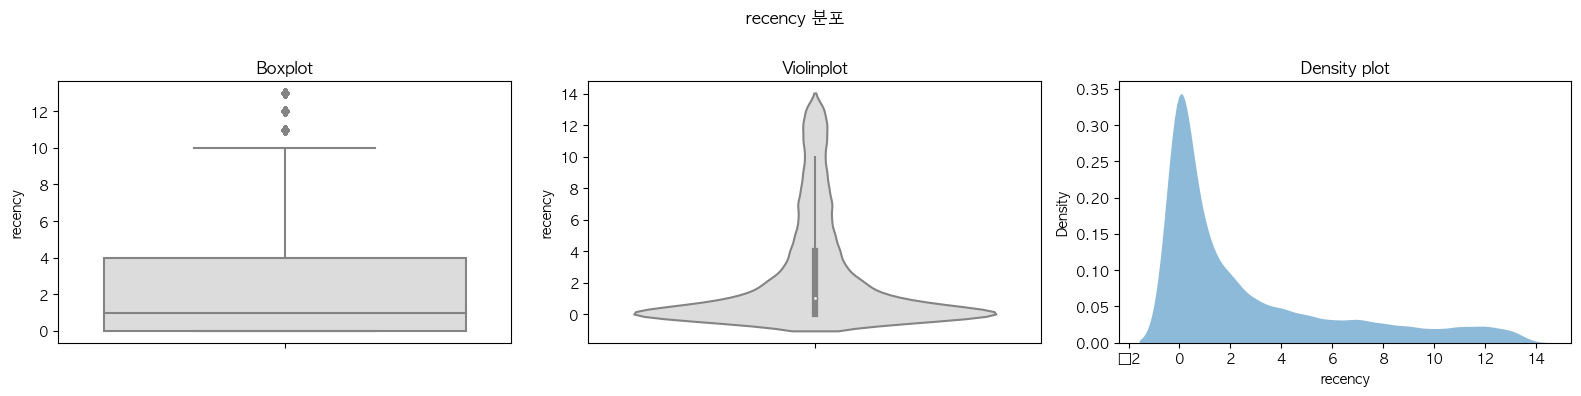

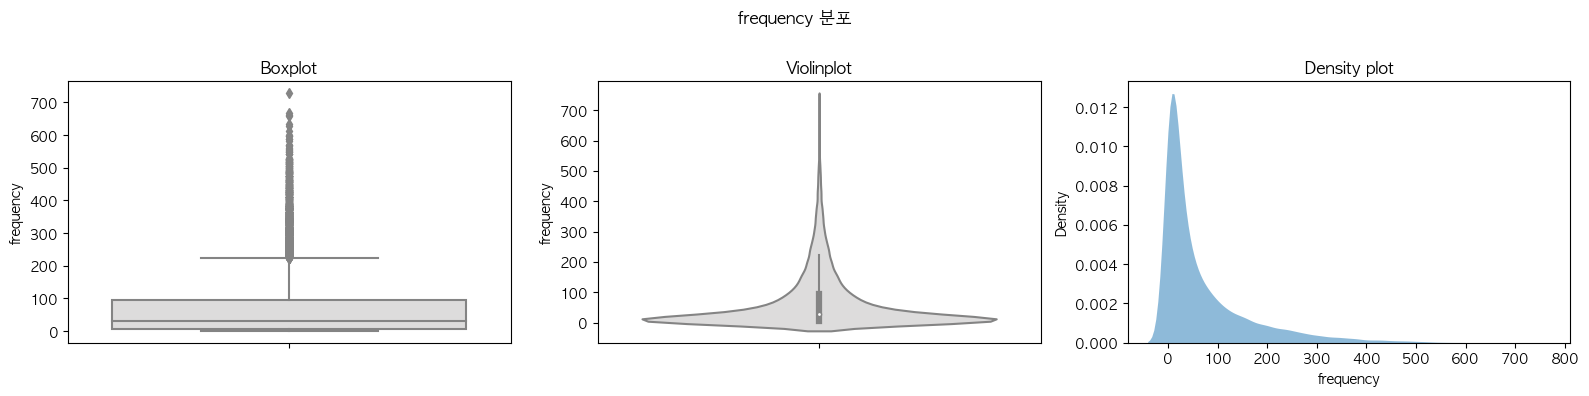

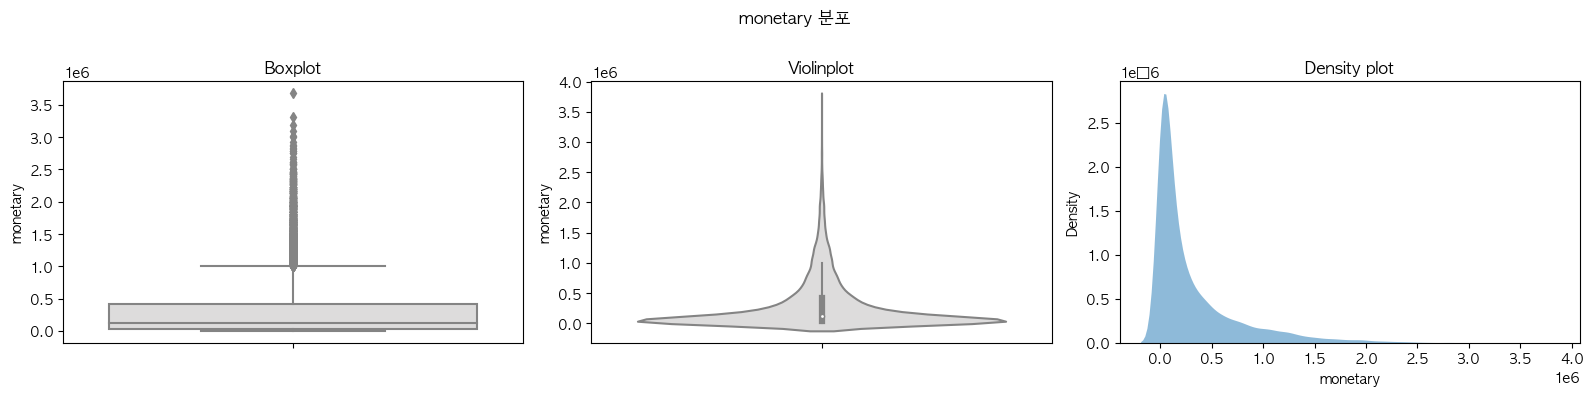

In [5]:
def plot_numeric (data, numeric_vars):
        
    palette = 'coolwarm'
    
    for num_var in numeric_vars:
        fig, axs = plt.subplots(1,3, figsize=(16,4))
        fig.suptitle(f'{num_var} 분포', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=axs[0],  y=num_var, data= data, palette = palette)
        axs[0].set_title('Boxplot')
    
        # Violinplot
        sns.violinplot(ax=axs[1],  y = num_var, data = data, palette = palette)
        axs[1].set_title('Violinplot')
        
        # KDE plot
        sns.kdeplot(ax=axs[2], data = data, x = num_var, fill = True, common_norm = False, palette = palette, alpha=.5, linewidth=0)
        axs[2].set_title('Density plot')
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) # title 공간 확보
        
        plt.show()
        plt.close(fig)

numeric_vars = ['recency', 'frequency', 'monetary']
plot_numeric(df, numeric_vars)

In [20]:
def percentile_df(data, variable_name):
    group1 = data[variable_name].quantile(0.25)
    group2 = data[variable_name].quantile(0.50)
    group3 = data[variable_name].quantile(0.75)
    IQR = group3 - group1
    group4 = group3 + 1.5 * IQR

    def categorize(val):
        if val <= group1:
            return 1
        elif group1 < val <= group2:
            return 2
        elif group2 < val <= group3:
            return 3
        elif group3 < val <= group4:
            return 4
        elif group4 < val:
            return 5

    data[f'{variable_name}_group'] = data[variable_name].apply(categorize)
    return data


In [21]:
percentile_df(df, 'recency')
percentile_df(df, 'frequency')
percentile_df(df, 'monetary')

df.head()

,brms_rider_id,JOIN_WEEK,recency,frequency,monetary,recency_group,frequency_group,monetary_group
0,0B1AFC83F0ABA185D69F238CA38817791227025787B0BF...,8W1D,NaN,NaN,NaN,NaN,NaN,NaN
1,8B68038033A87B076AC10E6896868EB90A2FEE35058C86...,9W4D,NaN,NaN,NaN,NaN,NaN,NaN
2,21ACD40CE2D0C17B98BDA2F4779D3091D62E69E1DF7015...,10W4D,0.0,30.0,124780.0,1.0,2.0,2.0
3,3778E0082306F550D1DD2808804ECE84B344C0ED704B61...,10W1D,7.0,8.0,30420.0,4.0,2.0,2.0
4,937FEC525E55B88A859AF5C81B090F4A79C968C9798F70...,8W3D,0.0,208.0,997980.0,1.0,4.0,4.0


In [23]:
print(df['recency_group'].value_counts())

recency_group
1.0    6355
3.0    2926
4.0    2510
2.0    2098
5.0     952
Name: count, dtype: int64


In [24]:
print(df['frequency_group'].value_counts())

frequency_group
1.0    3803
2.0    3713
3.0    3626
4.0    2465
5.0    1234
Name: count, dtype: int64


In [25]:
print(df['monetary_group'].value_counts())

monetary_group
1.0    3711
3.0    3711
2.0    3710
4.0    2416
5.0    1293
Name: count, dtype: int64


In [26]:
df['score'] = df['frequency_group'] + df['monetary_group'] + df['recency_group']
df['score'].describe()

count    14841.000000
mean         7.456303
std          2.107871
min          3.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         14.000000
Name: score, dtype: float64